In [161]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import groupby
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import nltk

from utils import helper
from utils import DataLoader, DataProcesser

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Routine PipLines

In [2]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [3]:
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [4]:
test_ratio = 0.2
col_label = 'label'
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, data.df[col_label], test_size = test_ratio)
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[col_label]

In [5]:
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)

In [6]:
pred_prob_rf = model_rf.predict_proba(X_val)

[[23761  4197    30   253   373  1081  2942   971]
 [  641 16704   770   852   272    52    55     4]
 [    2   183   489   614     5     7     0     0]
 [  133   698   856  8830  1759   444   269    10]
 [   12   224     8     1  8642    61  4934  1982]
 [  720  2195   616    91  3365  5774  1322  1046]
 [ 1383   932     1    12  5208   738 11376  3342]
 [ 3184  1016     4  1378   849  1021   910 14354]]
              precision    recall  f1-score   support

       Still       0.80      0.71      0.75     33608
     Walking       0.64      0.86      0.73     19350
         Run       0.18      0.38      0.24      1300
        Bike       0.73      0.68      0.71     12999
         Car       0.42      0.54      0.48     15864
         Bus       0.63      0.38      0.48     15129
       Train       0.52      0.49      0.51     22992
      Subway       0.66      0.63      0.65     22716

    accuracy                           0.62    143958
   macro avg       0.57      0.58      0.57    14

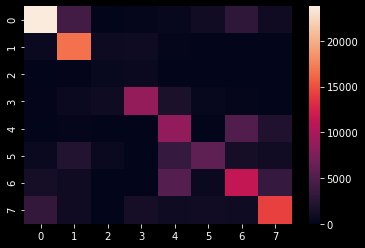

In [7]:
helper.evaluate(pred_rf, y_val)

---
# Post Process

In [8]:
import matplotlib.pyplot as plt

In [9]:
pred = pd.Series(pred_rf)
pred_prob = pred_prob_rf

In [10]:
def plot_prediction(y_pred, y_true):
    plt.figure(figsize = [20, 8])
    plt.plot(y_pred, alpha = 0.4)
    plt.plot(y_true)

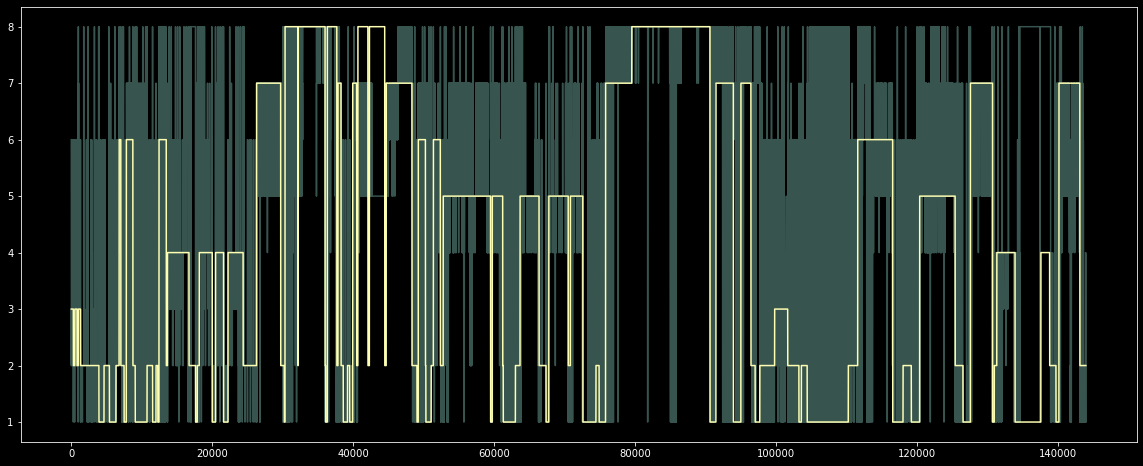

In [11]:
plot_prediction(pred, y_val)

## Mode

In [12]:
pred_mode = pred.rolling(90, center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')

[[25019  3805     0   158   409  1054  3120  1180]
 [  196 18347   618   561   138     1    26     0]
 [    0     8   528   215     0     0     0     0]
 [  103   175  1016  9852   761   525   134     0]
 [    0   209     0     0  8736     0  5251  1922]
 [  184  1650   612     0  3864  6037  1194   954]
 [ 1274   973     0     0  5616   481 11530  3298]
 [ 3060   982     0  1245   949  1080   553 14355]]
              precision    recall  f1-score   support

       Still       0.84      0.72      0.77     34745
     Walking       0.70      0.92      0.80     19887
         Run       0.19      0.70      0.30       751
        Bike       0.82      0.78      0.80     12566
         Car       0.43      0.54      0.48     16118
         Bus       0.66      0.42      0.51     14495
       Train       0.53      0.50      0.51     23172
      Subway       0.66      0.65      0.65     22224

    accuracy                           0.66    143958
   macro avg       0.60      0.65      0.60    14

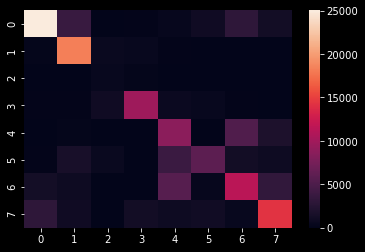

In [13]:
helper.evaluate(pred_mode, y_val)

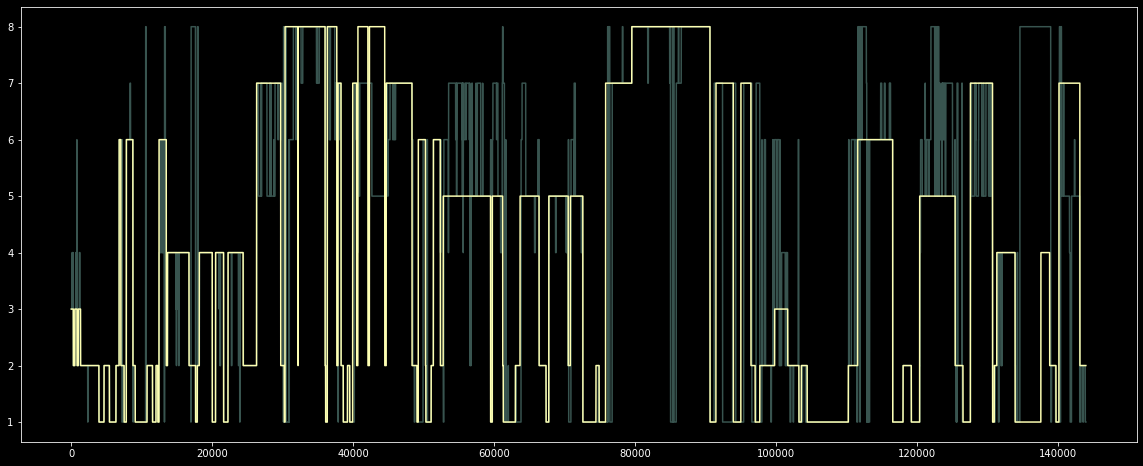

In [14]:
plot_prediction(pred_mode, y_val)

## Mean of Prob

In [15]:
pred_prob_mean = pd.DataFrame(pred_prob).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')

In [16]:
pred_mean = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[25159  3925     0   114   427  1090  2951  1199]
 [  142 18072   615   662   154    15    19     0]
 [    0     0   474   272     0     0     0     0]
 [   70    70  1051  9738   584   420   105     0]
 [   16   209     0     0  9289     0  5253  1943]
 [  139  1875   634     0  3995  6105   934   808]
 [ 1183   937     0     0  5254   611 11934  3123]
 [ 3127  1061     0  1245   770   937   612 14636]]
              precision    recall  f1-score   support

       Still       0.84      0.72      0.78     34865
     Walking       0.69      0.92      0.79     19679
         Run       0.17      0.64      0.27       746
        Bike       0.81      0.81      0.81     12038
         Car       0.45      0.56      0.50     16710
         Bus       0.67      0.42      0.52     14490
       Train       0.55      0.52      0.53     23042
      Subway       0.67      0.65      0.66     22388

    accuracy                           0.66    143958
   macro avg       0.61      0.65      0.61    14

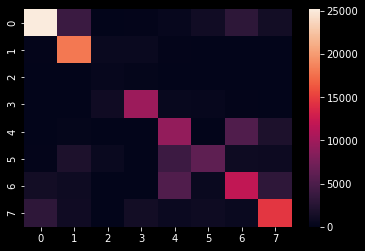

In [17]:
helper.evaluate(pred_mean, y_val)

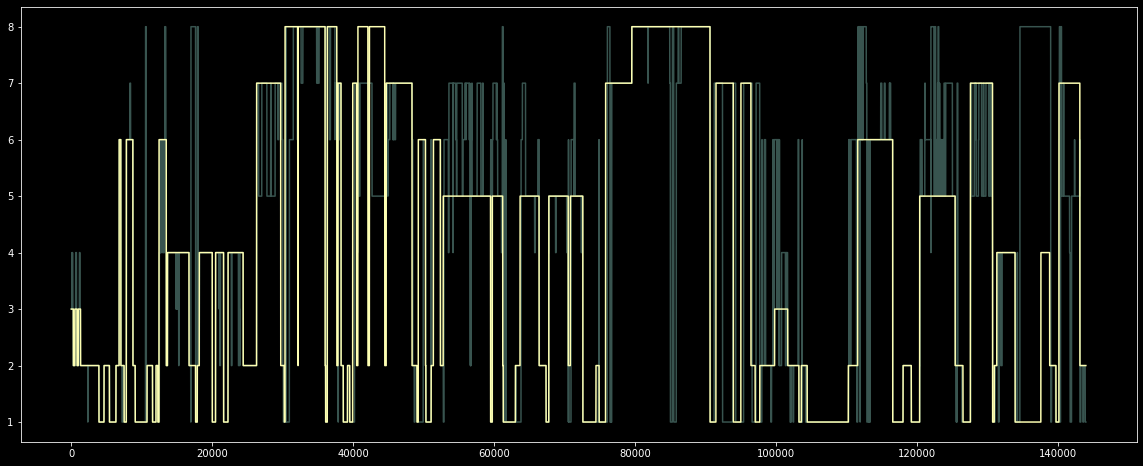

In [18]:
plot_prediction(pred_mean, y_val)

In [19]:
df_tmp = pd.DataFrame({"pred_mode": pred_mode, "pred_mean": pred_mean, "label": y_val})
df_tmp = df_tmp[df_tmp.pred_mode != df_tmp.pred_mean].reset_index(drop = True)

In [20]:
df_tmp['hit2'] = df_tmp.apply(lambda x: int((x['pred_mode'] == x['label']) | (x['pred_mean'] == x['label'])), axis = 1)

In [21]:
Counter(df_tmp['hit2'])

Counter({1: 5205, 0: 1902})

## Rule-Based Method

- Duration Restriction
- Transition Banning

In [306]:
def get_group_conscount(sr):
    groups = groupby(sr.values.tolist())
    grouped_elements = [list(group) for key, group in groups]
    dur_df = pd.DataFrame({"label": [t[0] for t in grouped_elements],
                        "duration": [len(t) for t in grouped_elements]})
    return dur_df

In [307]:
df_dur = get_group_conscount(pred_mode)
df_dur['cons_state_index'] = df_dur.index

In [308]:
df_res = pd.DataFrame({'pred': pred_mode})
df_res['cons_state_index'] = (df_res['pred'].diff(1) != 0).astype('int').cumsum() - 1
df_res = pd.merge(df_res, df_dur, on = 'cons_state_index')

In [309]:
df_res['pred_last'] = df_res['pred'].shift(1).fillna(method = 'bfill').astype('int')

In [310]:
rule_time_dic = dict({1: 30, 2: 10, 3: 30, 4: 30, 5:30, 6: 30, 7: 30, 8: 30})

In [311]:
rule_trans_map = np.array(pd.read_table('data/transition_rule.txt', sep = ',', header = None))

In [312]:
pred_rule = df_res['pred'].copy()
for i in range(df_res.shape[0]):
    if df_res['duration'][i] < rule_time_dic[df_res['pred'][i]]:
        pred_rule[i] = df_res['pred_last'][i]
        df_res['pred_last'][i+1] = pred_rule[i]
    # transition rule
    if rule_trans_map[df_res['pred_last'][i]-1, df_res['pred'][i]-1] == 0:
        pred_rule[i] = df_res['pred_last'][i]
        df_res['pred_last'][i+1] = pred_rule[i]

[[25159  3925     0   114   427  1090  2951  1199]
 [  142 18072   615   662   154    15    19     0]
 [    0     0   474   272     0     0     0     0]
 [   70    70  1051  9738   584   420   105     0]
 [   16   209     0     0  9289     0  5253  1943]
 [  139  1875   634     0  3995  6105   934   808]
 [ 1183   937     0     0  5254   611 11934  3123]
 [ 3127  1061     0  1245   770   937   612 14636]]
              precision    recall  f1-score   support

       Still       0.84      0.72      0.78     34865
     Walking       0.69      0.92      0.79     19679
         Run       0.17      0.64      0.27       746
        Bike       0.81      0.81      0.81     12038
         Car       0.45      0.56      0.50     16710
         Bus       0.67      0.42      0.52     14490
       Train       0.55      0.52      0.53     23042
      Subway       0.67      0.65      0.66     22388

    accuracy                           0.66    143958
   macro avg       0.61      0.65      0.61    14

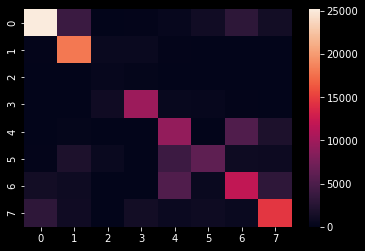

In [304]:
helper.evaluate(pred_mean, y_val)

[[24359  3567     0   158   439  1047  2991  1185]
 [  196 17675   657   666   133     1    26     0]
 [    0     0   576   113     0     0     0     0]
 [  103   171   952  9833   697   481    92     0]
 [    0   248     0     0  2367     0  8308    92]
 [  184  1593   589     0 15564  7550   488  6127]
 [ 1276  1026     0     0  1273     0  9269 13733]
 [ 3718  1869     0  1261     0    99   634   572]]
              precision    recall  f1-score   support

       Still       0.82      0.72      0.77     33746
     Walking       0.68      0.91      0.78     19354
         Run       0.21      0.84      0.33       689
        Bike       0.82      0.80      0.81     12329
         Car       0.12      0.21      0.15     11015
         Bus       0.82      0.24      0.37     32095
       Train       0.43      0.35      0.38     26577
      Subway       0.03      0.07      0.04      8153

    accuracy                           0.50    143958
   macro avg       0.49      0.52      0.45    14

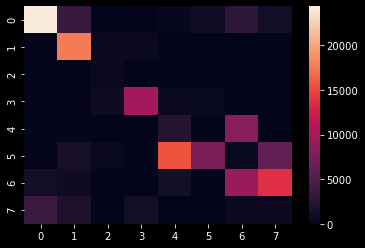

In [305]:
helper.evaluate(pred_rule, y_val)

In [279]:
df_dur2 = get_group_conscount(pred_rule)

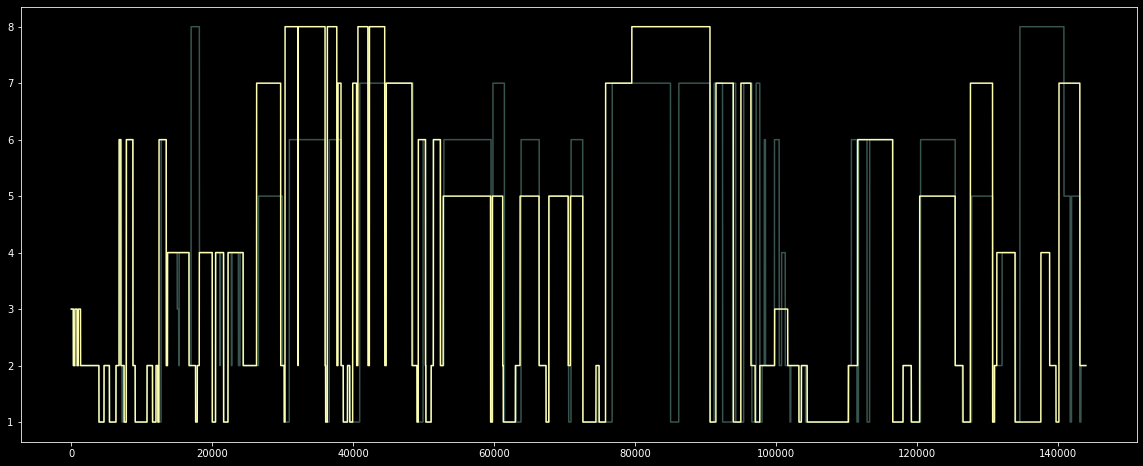

In [290]:
plot_prediction(pred_rule, y_val)

In [280]:
df_dur2.groupby('label').min()

,duration
label,
1,109
2,46
3,211
4,456
5,880
6,171
7,438
8,1178


## Transition

In [173]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp

array([[ 0., 23.,  4., 21.,  8., 45., 32., 23.],
       [60.,  0., 12., 21., 15., 15., 16., 22.],
       [ 8., 11.,  0.,  6.,  6.,  3.,  2.,  0.],
       [28., 23.,  5.,  0.,  6.,  2.,  4.,  0.],
       [ 8., 11.,  7.,  8.,  0.,  0.,  0.,  0.],
       [17., 42.,  7.,  2.,  0.,  0.,  0.,  0.],
       [17., 24.,  0.,  9.,  0.,  3.,  0.,  2.],
       [18., 27.,  1.,  0.,  0.,  0.,  1.,  0.]])

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 0 1 0 0]
 [1 1 0 1 0 1 1 1]
 [1 1 1 0 0 0 1 1]]


<AxesSubplot:>

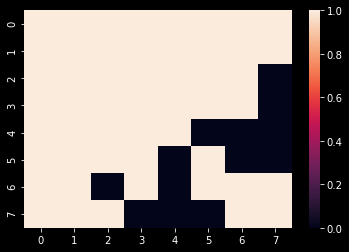

In [215]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp = 1-(tmp == 0).astype('int') + np.diag([1]*8)
print(tmp)
sns.heatmap(tmp)

<AxesSubplot:>

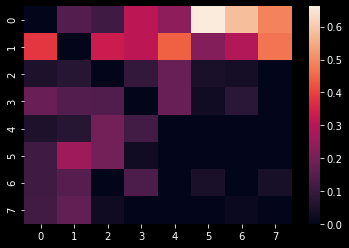

In [146]:
sns.heatmap(tmp / tmp.sum(axis = 1)) # axis = 1 求行和

In [112]:
# plt.figure(figsize = [12, 6])
# sns.boxplot(x = df_dur['label'], y = df_dur['duration'])